In [1]:
import os
import itertools, collections
import numpy, scipy, pandas
import scipy.signal
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from imp import reload
import seaborn

from pgtools import toolbox, myplots
import pygbrowse

import empdist
import peas
from peas.utilities import log_print

## Use empirical dataset

In [2]:
hic_corrs_fname = '/home/dskola/projects/coupled_peaks/hic/c57_hic_corrs_chr19.tsv'
%time hic_corrs = pandas.read_csv(hic_corrs_fname, sep='\t', index_col=0)

CPU times: user 11.7 s, sys: 573 ms, total: 12.3 s
Wall time: 12.3 s


## Trim matrix

In [3]:
from peas.arrayfuncs import replace_nans_diagonal_means, compute_vector_trim_points, compute_matrix_trim_points, \
    create_diagonal_distance_matrix, create_data_masks

def trim_data_matrix(input_matrix):
    row_start_trim_point, row_end_trim_point, col_start_trim_point, col_end_trim_point = compute_matrix_trim_points(
        input_matrix)
    trimmed_matrix = input_matrix[row_start_trim_point:row_end_trim_point, col_start_trim_point:col_end_trim_point]
    log_print('trimmed {} x {} matrix to remove contiguous NaNs, now {} x {}.'.format(*input_matrix.shape,
                                                                                      *trimmed_matrix.shape))
    return trimmed_matrix

In [4]:
trimmed_corrs = replace_nans_diagonal_means(trim_data_matrix(hic_corrs.values))

2018-Sep-05 19:32:01	trimmed 6134 x 6134 matrix to remove contiguous NaNs, now 5825 x 5825.


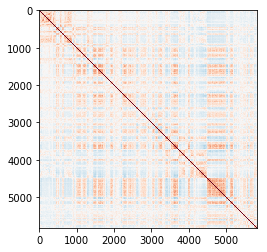

In [5]:
plt.imshow(trimmed_corrs, vmin=-0.5, vmax=0.5, cmap='RdBu_r')

# Baseline, without C

In [25]:
peas.constants.USE_C = False

In [26]:
%time real_sums_py = peas.scoring.compute_sum_table_2d(trimmed_corrs, start_diagonal=2, end_diagonal=1000)

CPU times: user 5.76 s, sys: 414 ms, total: 6.18 s
Wall time: 551 ms


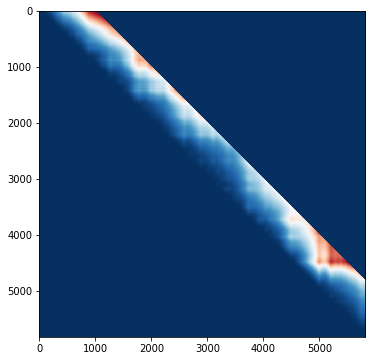

In [27]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(real_sums_py, cmap='RdBu_r')

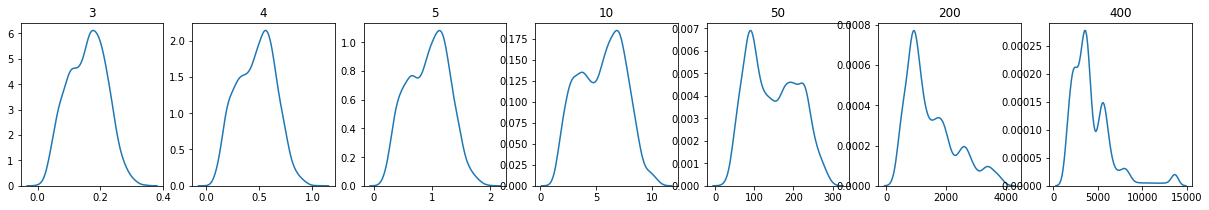

In [28]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_sums = numpy.diag(real_sums_py, region_size-1)
    seaborn.kdeplot(region_sums, ax=ax)
    ax.set_title(region_size)

In [29]:
target_pvalue = 1e-4
shuffles_needed = empdist.empirical_pval.compute_number_of_permuted_data_points(target_pvalue, 0.05) / trimmed_corrs.shape[0]
shuffles_needed

686.6951072961374

In [33]:
%%time

shuffled_means_py = peas.region_stats.generate_permuted_matrix_scores(trimmed_corrs, 
                                                                   num_shuffles=50, 
                                                                   min_region_size=3,
                                                                   start_diagonal=2,
                                                                   max_region_size=1000,
                                                                   random_seed=1)

2018-Sep-05 19:35:07			setting random seed to 1
2018-Sep-05 19:35:07			permutation 1 of 50
2018-Sep-05 19:35:13			permutation 2 of 50
2018-Sep-05 19:35:20			permutation 3 of 50
2018-Sep-05 19:35:26			permutation 4 of 50
2018-Sep-05 19:35:32			permutation 5 of 50
2018-Sep-05 19:35:39			permutation 6 of 50
2018-Sep-05 19:35:45			permutation 7 of 50
2018-Sep-05 19:35:51			permutation 8 of 50
2018-Sep-05 19:35:57			permutation 9 of 50
2018-Sep-05 19:36:04			permutation 10 of 50
2018-Sep-05 19:36:10			permutation 11 of 50
2018-Sep-05 19:36:16			permutation 12 of 50
2018-Sep-05 19:36:23			permutation 13 of 50
2018-Sep-05 19:36:29			permutation 14 of 50
2018-Sep-05 19:36:35			permutation 15 of 50
2018-Sep-05 19:36:41			permutation 16 of 50
2018-Sep-05 19:36:48			permutation 17 of 50
2018-Sep-05 19:36:54			permutation 18 of 50
2018-Sep-05 19:37:00			permutation 19 of 50
2018-Sep-05 19:37:07			permutation 20 of 50
2018-Sep-05 19:37:13			permutation 21 of 50
2018-Sep-05 19:37:19			permutation 22

CPU times: user 5min 2s, sys: 12.7 s, total: 5min 15s
Wall time: 5min 15s


In [34]:
%time shuffled_means_py = {size:numpy.sort(data) for size, data in shuffled_means_py.items()}

CPU times: user 5min 2s, sys: 19.7 s, total: 5min 21s
Wall time: 18.1 s


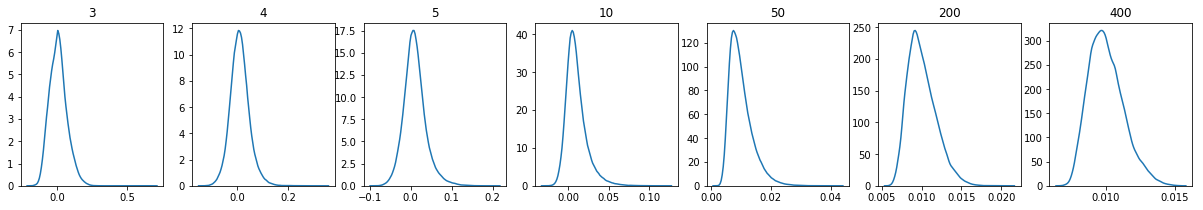

In [35]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_sums = shuffled_means_py[region_size]
    seaborn.kdeplot(region_sums, ax=ax)
    ax.set_title(region_size)

# With C

In [36]:
peas.constants.USE_C = True

In [37]:
%time real_sums_c = peas.scoring.compute_sum_table_2d(trimmed_corrs, start_diagonal=2, end_diagonal=1000)

CPU times: user 5.4 s, sys: 877 ms, total: 6.28 s
Wall time: 314 ms


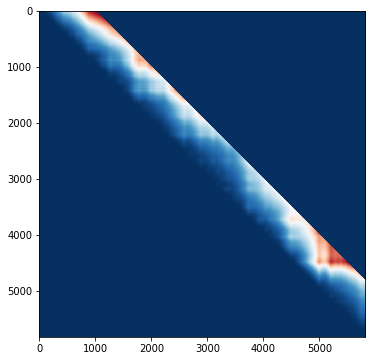

In [38]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(real_sums_c, cmap='RdBu_r')

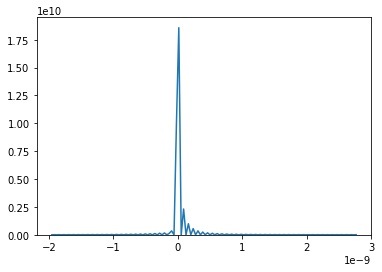

In [39]:
seaborn.kdeplot((real_sums_c - real_sums_py).flatten())

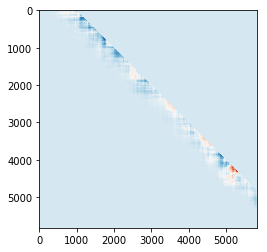

In [40]:
plt.imshow(real_sums_c - real_sums_py, cmap='RdBu_r')

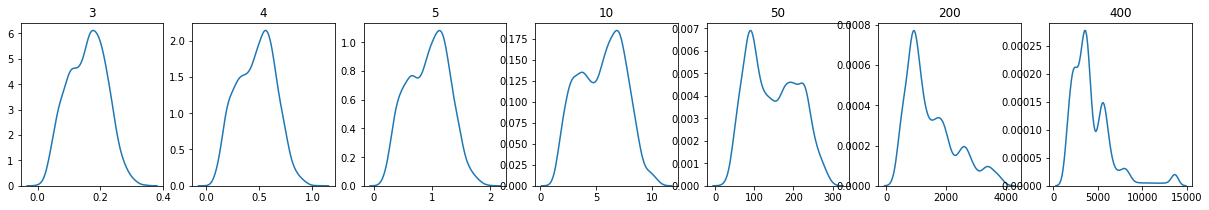

In [41]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = numpy.diag(real_sums_c, region_size-1)
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)

In [42]:
reload(peas)
reload(peas.scoring)
reload(peas.region_stats)

<module 'peas.region_stats' from '/gpfs/data01/glasslab/home/dskola/workspace/PEAS/peas/region_stats.py'>

In [43]:
target_pvalue = 1e-4
shuffles_needed = empdist.empirical_pval.compute_number_of_permuted_data_points(target_pvalue, 0.05) / trimmed_corrs.shape[0]
shuffles_needed

686.6951072961374

In [44]:
shuffled_means_c = peas.region_stats.generate_permuted_matrix_scores(trimmed_corrs, 
                                                                   num_shuffles=50, 
                                                                   min_region_size=3,
                                                                   start_diagonal=2,
                                                                   max_region_size=1000,
                                                                   random_seed=1)

2018-Sep-05 19:40:47			setting random seed to 1
2018-Sep-05 19:40:47			permutation 1 of 50
2018-Sep-05 19:40:53			permutation 16 of 50
2018-Sep-05 19:40:58			permutation 30 of 50
2018-Sep-05 19:41:03			permutation 45 of 50


In [45]:
%time shuffled_means_c = {size:numpy.sort(data) for size, data in shuffled_means_c.items()}

CPU times: user 5min 16s, sys: 16.3 s, total: 5min 32s
Wall time: 18.2 s


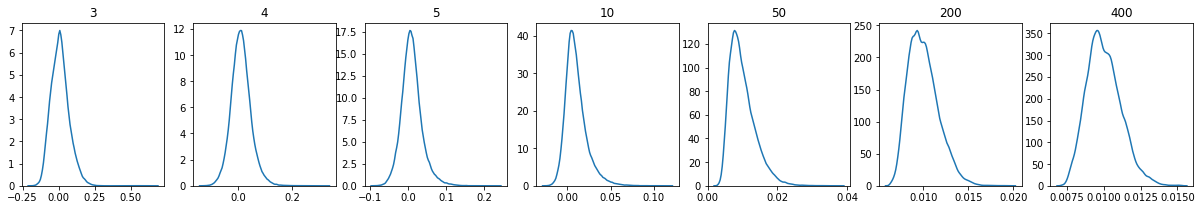

In [47]:
REGION_SIZES = (3, 4, 5, 10, 50, 200, 400)
fig_size = 3
fig, axes = plt.subplots(1, len(REGION_SIZES), figsize=(fig_size*len(REGION_SIZES), fig_size), sharex=False, sharey=False)
for region_size, ax in zip(REGION_SIZES, axes):
    region_means = shuffled_means_c[region_size]
    seaborn.kdeplot(region_means, ax=ax)
    ax.set_title(region_size)